<center>

# DATA PROCESS 

</center>

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import chi2_contingency
import seaborn as sns
import time
import os
import requests
import numpy as np
from urllib.parse import quote
from dotenv import load_dotenv

In [ ]:
api_key = os.environ.get('riot_api_key')
gameName='C9 Loki'
tagLine='kr3'
encoded_gameName = quote(gameName)
def get_puuid(encoded_gameName= None, tagLine= None, api_key =None):
    link = f'https://americas.api.riotgames.com/riot/account/v1/accounts/by-riot-id/{encoded_gameName}/{tagLine}?api_key={api_key}'
    response = requests.get(link)
    return response.json()['puuid']

def get_ladder():
    root= 'https://na1.api.riotgames.com/'
    chall ='lol/league/v4/challengerleagues/by-queue/RANKED_SOLO_5x5'
    gm='lol/league/v4/grandmasterleagues/by-queue/RANKED_SOLO_5x5'
    masters= 'lol/league/v4/masterleagues/by-queue/RANKED_SOLO_5x5'

    chall_response = requests.get(root + chall + '?api_key=' + api_key)
    gm_response = requests.get(root + gm + '?api_key=' + api_key)
    masters_response = requests.get(root + masters + '?api_key=' + api_key)

    chall_df = pd.DataFrame(chall_response.json()['entries'])
    gm_df = pd.DataFrame(gm_response.json()['entries'])
    masters_df = pd.DataFrame(masters_response.json()['entries'])
    ladder = pd.concat([chall_df,gm_df,masters_df])[0:3].reset_index(drop=True)
    ladder = ladder.drop(columns='rank').reset_index(drop=False).rename(columns={'index':'rank'})
    ladder['rank'] += 1
    return ladder
get_ladder()

,rank,summonerId,puuid,leaguePoints,wins,losses,veteran,inactive,freshBlood,hotStreak
0,1,maYLpP6UcQ7nHljVG9OUed9bsMDsUgfWNV850797OCZt6gsm,cj4DORyJ_G7VvIiffvUDig4muakikWgmGojZlz0bhSYXV9...,1986,246,182,True,False,False,True
1,2,VpOXU5hy0nHly6vHcEkAo7gyGzU7HT7lD7a1_QGZPill1B...,cceyLZQy9agglDZRVGQX2xW9VhMjbJhY106gIr3Kkpqttp...,1982,285,192,True,False,False,False
2,3,UNgKaRECN7EamOpBFcq9OYoLEgus4Y6nQkQyhZyTrckYQVSD,8FatGe1yA8dF3ho_KWD4AO4MkeT3mRaiPvLInPl7gSAZ5Y...,1891,154,88,True,False,False,True


Riot developer tool provides high elo players' information. I wrote a get_ladder function to store challanger player's information.

In [58]:
df = get_ladder()
df = df[['summonerId', 'puuid', 'leaguePoints', 'wins', 'losses', 
         'veteran', 'inactive', 'freshBlood', 'hotStreak']]
df.to_csv('ladder_puuids.csv', index=False)
df = pd.read_csv('ladder_puuids.csv')
puuids = df['puuid'].tolist()
puuids

['cj4DORyJ_G7VvIiffvUDig4muakikWgmGojZlz0bhSYXV9dJBSFBA5qoBf6Xewjn4q7fpjNzsla98g',
 'cceyLZQy9agglDZRVGQX2xW9VhMjbJhY106gIr3KkpqttpPDoL-cbd-yns_mEm6zEN1YpS-19iVc8w',
 '8FatGe1yA8dF3ho_KWD4AO4MkeT3mRaiPvLInPl7gSAZ5YAO1BYo2i1EWit6X7ZlNExoteeevQZ8kA']

I extracted the puuids of high elo players, so that I can interact players one by one to get match_ids.

In [34]:
def get_match_history(region=None, puuid=None, start=0, count=50, queue=420):
    root_url = f'https://{region}.api.riotgames.com'
    endpoint = f'/lol/match/v5/matches/by-puuid/{puuid}/ids'
    query_params = f'?start={start}&count={count}&queue={queue}'
    response = requests.get(root_url + endpoint + query_params + '&api_key=' + api_key)
    return response.json()

def get_match_data_from_id(region= None,matchId=None):
    root_url= f'https://{region}.api.riotgames.com/'
    endpoint = f'/lol/match/v5/matches/{matchId}'

    response = requests.get(root_url + endpoint  +'?api_key=' +api_key)
    return response.json()

data = get_match_data_from_id(region='americas', matchId='NA1_5274110401')


get_match_history takes the puuid and returns list of match_ids. I can choose how many matches I want to get.
get_match_data_from_id return the raw data that includes everything related to the given match_id.

In [35]:
def process_match_json(match_json, puuid):

    side_dict = {
        100:'blue',
        200:'red'
    }

    try:
        info = match_json['info']


        metadata = match_json['metadata']
        matchId = metadata['matchId']
        participants = metadata['participants']

        player = info['participants'][participants.index(puuid)]
        gameStartTimestamp = info['gameStartTimestamp']
        gameEndTimestamp = info['gameEndTimestamp']
        timePlayed = int((gameEndTimestamp-gameStartTimestamp)/1000//60)
        puuid = player['puuid']
  
        try:
            riotIdTagLine = player['riotIdTagline']
        except:
            riotIdTagLine = ''
        side = side_dict[player['teamId']]
        win = player['win']
        surrender = player['gameEndedInSurrender']
        totalMinionsKilled = player['totalMinionsKilled']
        totalDamageDealtToChampions = player['totalDamageDealtToChampions']
        visionScore = player['visionScore']

        matchDF = pd.DataFrame({
            'match_id': [matchId],
            'puuid': [puuid],
            'win': [win],
            'total_minions_killed': [totalMinionsKilled],
            'surrender': [surrender],
            'total_damage_dealt_champions': [totalDamageDealtToChampions],
            'vision_score': [visionScore],
            'time_played':[timePlayed],

        })
    
        return matchDF
    except:
        return pd.DataFrame()

process_match_json processes the raw data. I can manipulate it to process any parameter I want.

In [59]:
all_rows = []
puuidlist=['cceyLZQy9agglDZRVGQX2xW9VhMjbJhY106gIr3KkpqttpPDoL-cbd-yns_mEm6zEN1YpS-19iVc8w']
request_count=0
for puuid in puuidlist:
    match_ids = get_match_history(region='americas',puuid=puuid,start=0, count=3) 
    request_count += 1
    time.sleep(1)

    for match_id in match_ids:
        try:
            match_json = get_match_data_from_id("americas", match_id)
            match_df = process_match_json(match_json, puuid)

            if not match_df.empty:
                all_rows.append(match_df)
            
            request_count+=1
            time.sleep(0.2)
            if request_count >= 95:
                print('Waiting for 2 min')
                time.sleep(120)
                request_count=0

        except Exception as e:
            print(f"Error with match {match_id} for puuid {puuid}: {e}")


df = pd.concat(all_rows, ignore_index=True)
print(f"Final dataframe shape: {df.shape}")
df['minionsPerMinute'] = (df['total_minions_killed'] / df['time_played']).round(2)
df['visionScorePerMinute'] = (df['vision_score'] / df['time_played']).round(2)
df['damageDealtPerMinute'] = (df['total_damage_dealt_champions'] / df['time_played']).round(2)
df #df.to_csv('challanger_data.csv', index=False)

Final dataframe shape: (3, 8)


,match_id,puuid,win,total_minions_killed,surrender,total_damage_dealt_champions,vision_score,time_played,minionsPerMinute,visionScorePerMinute,damageDealtPerMinute
0,NA1_5291514544,cceyLZQy9agglDZRVGQX2xW9VhMjbJhY106gIr3Kkpqttp...,False,255,False,43321,40,38,6.71,1.05,1140.03
1,NA1_5291492519,cceyLZQy9agglDZRVGQX2xW9VhMjbJhY106gIr3Kkpqttp...,False,199,True,12197,20,22,9.05,0.91,554.41
2,NA1_5291478137,cceyLZQy9agglDZRVGQX2xW9VhMjbJhY106gIr3Kkpqttp...,False,126,True,8011,9,16,7.88,0.56,500.69


In order to process low elo matches, I used op.gg to get low elo players' nicknames and taglines. After that, I got their puuids by using my functions, and made a list.

I processed the parameters as per-minute ratios to prevent long games from causing misinterpretation.

Matches that ended early due to an AFK player were treated as outliers and removed, as they do not accurately represent player performance.

During data collection, I ensured an equal distribution of roles between Challenger and low elo matches to avoid bias. An imbalance, such as having more support players, could distort the findings.

I also added my own match data to make it more interesting.


<center>

# Exploratory Data Analysis and Visualization

</center>


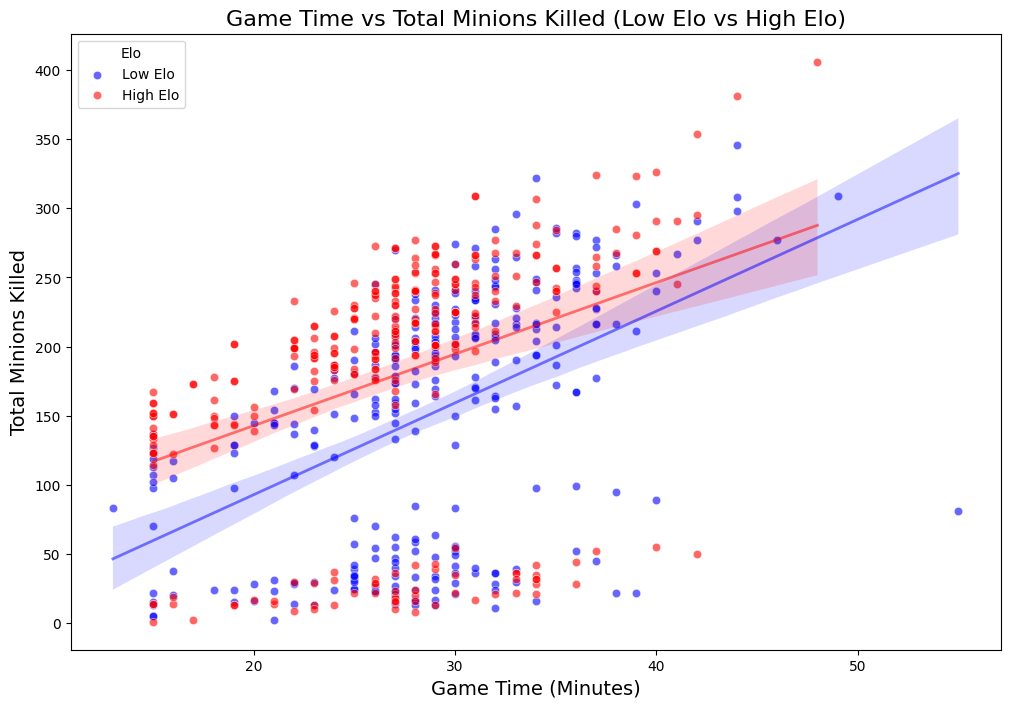

In [3]:
low_elo_df = pd.read_csv('low_elo_data.csv')  
high_elo_df = pd.read_csv('challenger_data.csv')  
plt.figure(figsize=(12, 8))
sns.scatterplot(x='time_played', y='total_minions_killed', data=low_elo_df, color='blue', label='Low Elo', alpha=0.6)
sns.scatterplot(x='time_played', y='total_minions_killed', data=high_elo_df, color='red', label='High Elo', alpha=0.6)
sns.regplot(x='time_played', y='total_minions_killed', data=low_elo_df, scatter=False, color='blue', line_kws={"color": "blue", "alpha": 0.5, "lw": 2})
sns.regplot(x='time_played', y='total_minions_killed', data=high_elo_df, scatter=False, color='red', line_kws={"color": "red", "alpha": 0.5, "lw": 2})

plt.title('Game Time vs Total Minions Killed (Low Elo vs High Elo)', fontsize=16)
plt.xlabel('Game Time (Minutes)', fontsize=14)
plt.ylabel('Total Minions Killed', fontsize=14)
plt.legend(title="Elo", loc='upper left')

plt.show()

High elo players are more skilled and consistent at slaying minions compared to low elo players. Low elo players often struggle with last-hitting in the early game, as it requires precise timing and mechanics. In the late game, however, they can one-shot minions more easily, which helps close the gap. Despite this, Challenger players still outperform low elo players in minion kills throughout all phases of the game.

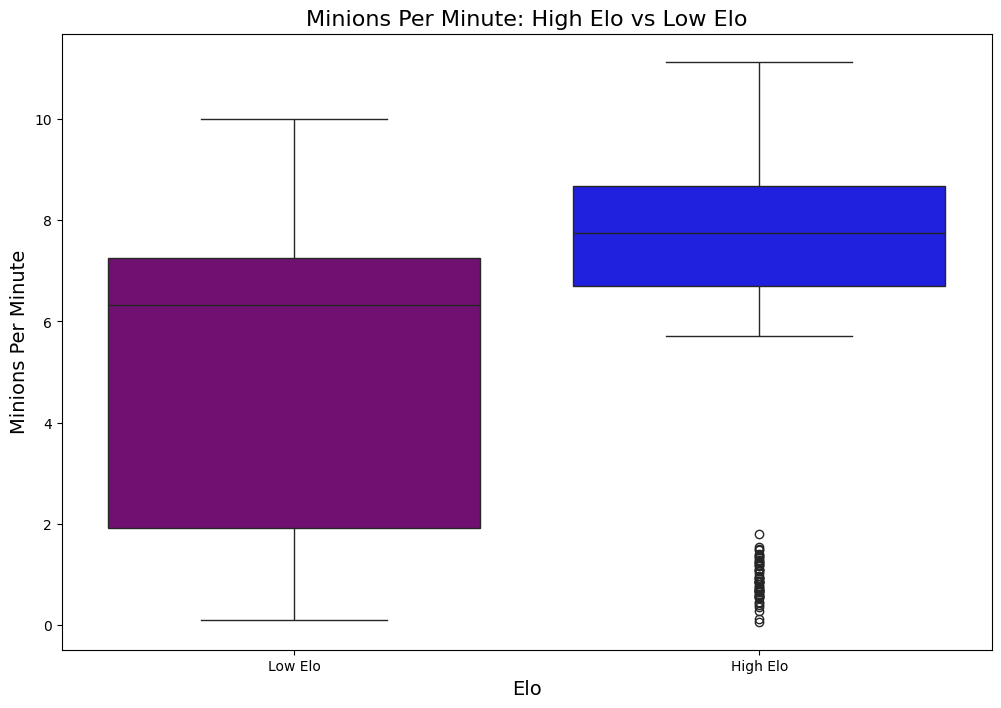

In [37]:
low_elo_df['elo'] = 'Low Elo'
high_elo_df['elo'] = 'High Elo'
combined_df = pd.concat([low_elo_df[['minionsPerMinute', 'elo']], 
                         high_elo_df[['minionsPerMinute', 'elo']]])

plt.figure(figsize=(12, 8))
sns.boxplot(x='elo', y='minionsPerMinute',hue='elo', data=combined_df,palette={'Low Elo': 'purple', 'High Elo': 'blue'},dodge=False)
plt.title('Minions Per Minute: High Elo vs Low Elo', fontsize=16)
plt.xlabel('Elo', fontsize=14)
plt.ylabel('Minions Per Minute', fontsize=14)
plt.show()

Overall, high elo players consistently perform well in farming minions, with support players being the main outliers, as they tend to slay fewer minions. On the other hand, the mean and median values for low elo players are relatively low. This means high elo players earn more gold and buy better items.

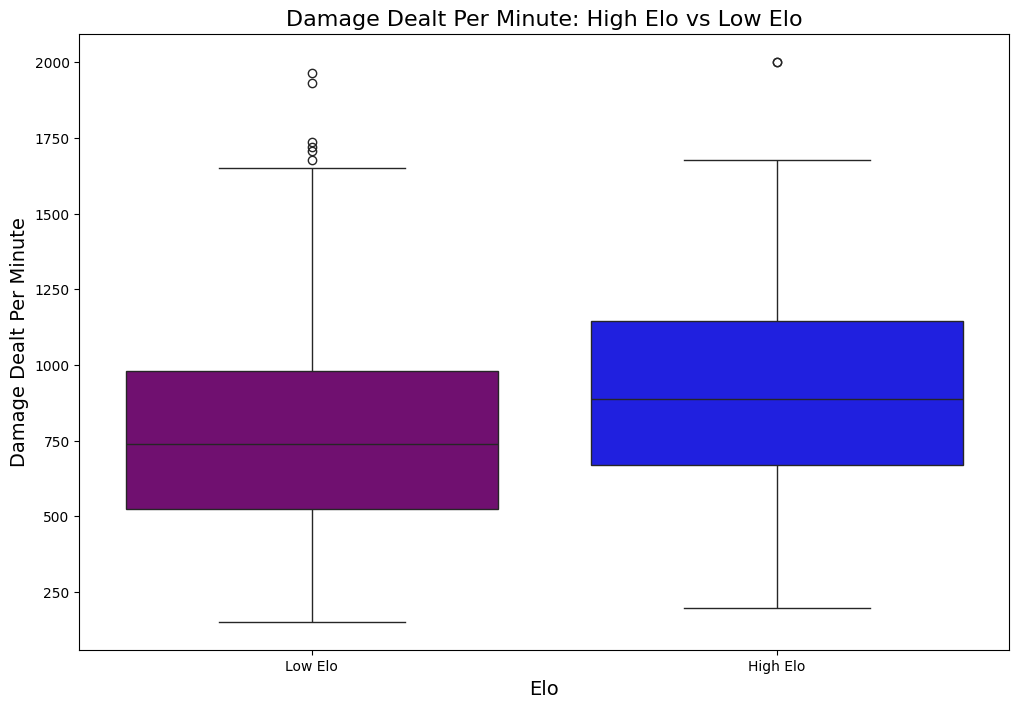

In [38]:
low_elo_df['elo'] = 'Low Elo'
high_elo_df['elo'] = 'High Elo'
combined_df = pd.concat([low_elo_df[['damageDealtPerMinute', 'elo']], 
                         high_elo_df[['damageDealtPerMinute', 'elo']]])

plt.figure(figsize=(12, 8))
sns.boxplot(x='elo', y='damageDealtPerMinute',hue='elo' ,data=combined_df , palette={'Low Elo': 'purple', 'High Elo': 'blue'},dodge=False)
plt.title('Damage Dealt Per Minute: High Elo vs Low Elo', fontsize=16)
plt.xlabel('Elo', fontsize=14)
plt.ylabel('Damage Dealt Per Minute', fontsize=14)

plt.show()

High Elo players are more consistent in dealing damage. In low Elo games, there is an imbalance and variability in damage dealt. High Elo players tend to have both higher averages and medians, indicating more reliable and effective performance across matches.

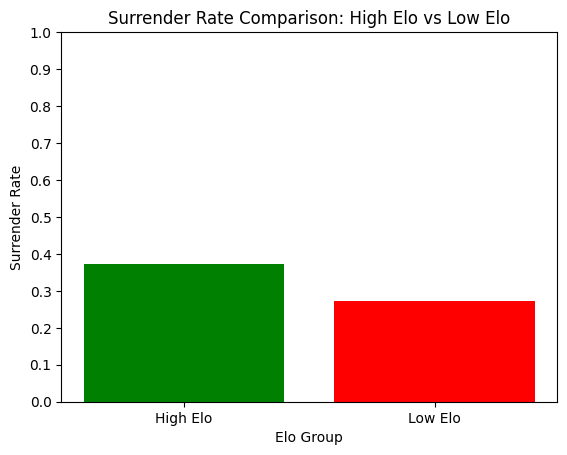

In [39]:
high_elo_surrender_rate = high_elo_df['surrender'].mean()
low_elo_surrender_rate = low_elo_df['surrender'].mean()
elo_groups = ['High Elo', 'Low Elo']
surrender_rates = [high_elo_surrender_rate, low_elo_surrender_rate]
plt.bar(elo_groups, surrender_rates, color=['green', 'red'])
plt.title('Surrender Rate Comparison: High Elo vs Low Elo')
plt.ylabel('Surrender Rate')
plt.xlabel('Elo Group')
plt.ylim(0, 1)  # Ensure the y-axis is from 0 to 1
plt.yticks(np.arange(0, 1.1, 0.1))  # Set ticks at intervals of 0.1 (0.0, 0.1, 0.2, ..., 1.0)

plt.show()

When it comes to surrender rates, Challenger players outperform low Elo players. Their ability to read the game allows them to recognize unwinnable situations and avoid wasting time. In contrast, low Elo players are more likely to avoid surrendering, continuing to play even when the odds of winning are extremely low.

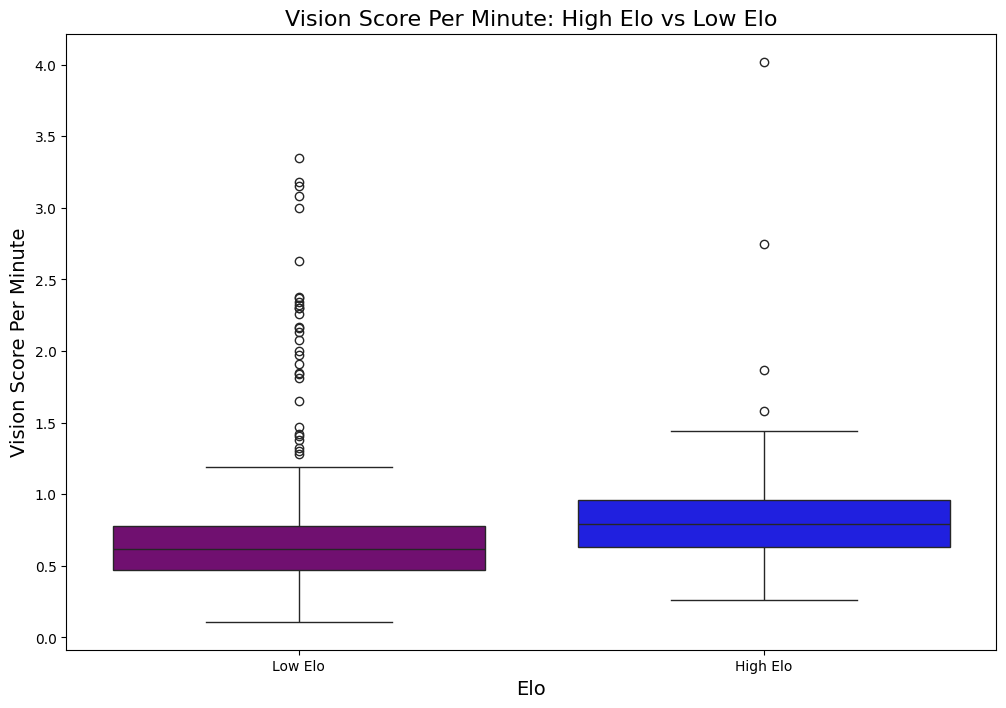

In [40]:
low_elo_df['elo'] = 'Low Elo'
high_elo_df['elo'] = 'High Elo'
combined_df = pd.concat([low_elo_df[['visionScorePerMinute', 'elo']], 
                         high_elo_df[['visionScorePerMinute', 'elo']]])
plt.figure(figsize=(12, 8))
sns.boxplot(x='elo', y='visionScorePerMinute',hue='elo', data=combined_df,palette={'Low Elo': 'purple', 'High Elo': 'blue'},dodge=False)
plt.title('Vision Score Per Minute: High Elo vs Low Elo', fontsize=16)
plt.xlabel('Elo', fontsize=14)
plt.ylabel('Vision Score Per Minute', fontsize=14)

plt.show()

Vision scores reflect a major gap in awareness between high and low Elo players. In high Elo, players across all roles consistently contribute to vision control, showing a clear understanding of its importance. In contrast, low Elo matches often rely solely on support players for vision, creating outliers while the overall average remains low. This suggests a lack of shared responsibility and game awareness in lower tiers.

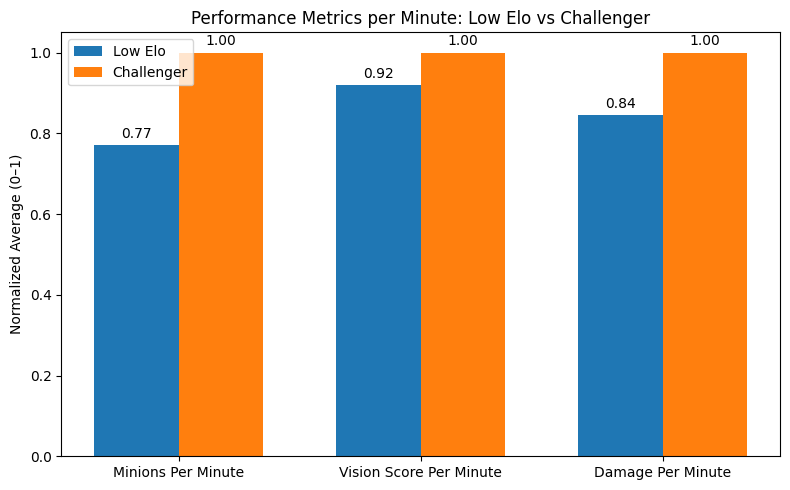

In [41]:
low_elo = pd.read_csv("low_elo_data.csv")
challenger = pd.read_csv("challenger_data.csv")
metrics = {
    "Minions Per Minute": [
        low_elo["minionsPerMinute"].mean(),
        challenger["minionsPerMinute"].mean()
    ],
    "Vision Score Per Minute": [
        low_elo["visionScorePerMinute"].mean(),
        challenger["visionScorePerMinute"].mean()
    ],
    "Damage Per Minute": [
        low_elo["damageDealtPerMinute"].mean(),
        challenger["damageDealtPerMinute"].mean()
    ]
}
normalized = {key: [val / max(vals) for val in vals] for key, vals in metrics.items()}
labels = list(normalized.keys())
low = [v[0] for v in normalized.values()]
high = [v[1] for v in normalized.values()]
x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, low, width, label='Low Elo')
bars2 = ax.bar(x + width/2, high, width, label='Challenger')
ax.set_ylabel('Normalized Average (0–1)')
ax.set_title('Performance Metrics per Minute: Low Elo vs Challenger')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
for bar_group in [bars1, bars2]:
    for bar in bar_group:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom')
plt.tight_layout()
plt.show()

It is evident that high elo players are more efficient and outperform low elo players in every category. They are more skilled at last-hitting minions, more aware of vision control, and deal more damage to the enemy team per minute.

<center>

# Hypothesis Testing

</center>


**Null Hypothesis (H0):** There is no significant difference between High Elo and Low Elo players in terms of minion score, damage dealt, vision score, and surrender behavior.

**Alternative Hypothesis (H1):** There is a significant difference between High Elo and Low Elo players in terms of minion score, damage dealt, vision score, and surrender behavior.

In order to assess whether there are significant differences in the game performance between high Elo and low Elo players, I used different statistical tests based on the nature of the data. For continuous variables such as damage dealt, minions slain, and vision score, I applied the independent two-sample t-test. This test is appropriate because I am comparing the means of these variables between two independent groups, high Elo and low Elo players.

For the surrender rate, however, I used the Chi-Square test because it involves categorical data (whether a player surrenders or not), and I wanted to assess whether the frequency of surrendering significantly differs between the two groups. The Chi-Square test is appropriate when comparing categorical outcomes between groups.

In [42]:
# Minions per minute test (T-test)
minions_low_elo = low_elo_df['minionsPerMinute']
minions_high_elo = high_elo_df['minionsPerMinute']
t_stat_minions, p_value_minions = stats.ttest_ind(minions_low_elo, minions_high_elo)
print("\n1. Minions Per Minute (T-test):")
print(f"T-statistic: {t_stat_minions:.2f}")
print(f"P-value: {p_value_minions:.4f}")
if p_value_minions < 0.05:
    print("Result: Reject Null Hypothesis - Significant difference in minions per minute.")
else:
    print("Result: Fail to Reject Null Hypothesis - No significant difference in minions per minute.")



1. Minions Per Minute (T-test):
T-statistic: -6.53
P-value: 0.0000
Result: Reject Null Hypothesis - Significant difference in minions per minute.


In [43]:
# Damage per minute test (T-test)
damage_low_elo = low_elo_df['total_damage_dealt_champions']
damage_high_elo = high_elo_df['total_damage_dealt_champions']
t_stat_damage, p_value_damage = stats.ttest_ind(damage_low_elo, damage_high_elo)
print("\n2. Damage Dealt per Minute (T-test):")
print(f"T-statistic: {t_stat_damage:.2f}")
print(f"P-value: {p_value_damage:.4f}")
if p_value_damage < 0.05:
    print("Result: Reject Null Hypothesis - Significant difference in damage dealt per minute.")
else:
    print("Result: Fail to Reject Null Hypothesis - No significant difference in damage dealt per minute.")


2. Damage Dealt per Minute (T-test):
T-statistic: -2.18
P-value: 0.0293
Result: Reject Null Hypothesis - Significant difference in damage dealt per minute.


In [45]:
# Vision score test (T-test)
vision_low_elo = low_elo_df['vision_score']
vision_high_elo = high_elo_df['vision_score']

t_stat_vision, p_value_vision = stats.ttest_ind(vision_low_elo, vision_high_elo)
print("\n3. Vision Score (T-test):")
print(f"T-statistic: {t_stat_vision:.2f}")
print(f"P-value: {p_value_vision:.4f}")
if p_value_vision < 0.05:
    print("Result: Reject Null Hypothesis - Significant difference in vision score.")
else:
    print("Result: Fail to Reject Null Hypothesis - No significant difference in vision score.")


3. Vision Score (T-test):
T-statistic: -0.56
P-value: 0.5762
Result: Fail to Reject Null Hypothesis - No significant difference in vision score.


In [65]:
# Surrender Rate test (T-test)
surrender_low_elo = low_elo_df['surrender'].value_counts()
surrender_high_elo = high_elo_df['surrender'].value_counts()
all_categories = sorted(set(surrender_low_elo.index).union(set(surrender_high_elo.index)))
low_counts = [surrender_low_elo.get(cat, 0) for cat in all_categories]
high_counts = [surrender_high_elo.get(cat, 0) for cat in all_categories]
contingency_table = [low_counts, high_counts]
chi2_stat, p_value_surrender, dof, expected = chi2_contingency(contingency_table)
print("\n4. Surrender Rate (Chi-Square Test):")
print(f"Chi-Square Statistic: {chi2_stat:.2f}")
print(f"P-value: {p_value_surrender:.4f}")
print(f"Degrees of Freedom: {dof}")
print(f"Expected Frequencies: \n{pd.DataFrame(expected, columns=all_categories, index=['Low Elo', 'High Elo'])}")

if p_value_surrender < 0.05:
    print("Result: Reject Null Hypothesis - Significant difference in surrender rate.")
else:
    print("Result: Fail to Reject Null Hypothesis - No significant difference in surrender rate.")



4. Surrender Rate (Chi-Square Test):
Chi-Square Statistic: 6.70
P-value: 0.0096
Degrees of Freedom: 1
Expected Frequencies: 
               False      True 
Low Elo   204.694491  97.305509
High Elo  201.305509  95.694491
Result: Reject Null Hypothesis - Significant difference in surrender rate.


**Conclusion:**
Based on the results of the hypothesis tests, I can draw the following conclusions regarding the impact of strategy and skills on players' ranks and performance in League of Legends:

**1.Minions per Minute:** The t-test for minions slain per minute reveals a significant difference (p-value < 0.05), with high Elo players killing more minions on average compared to low Elo players. This reinforces the idea that better farm management (last-hitting) is a key indicator of higher skill and ranking in the game as it allows players to buy better items and be stronger.

**2.Damage Dealt per Minute:** The t-test results show a significant difference in the average damage dealt per minute between high Elo and low Elo players (p-value < 0.05). This indicates that high Elo players consistently deal more damage than low Elo players, suggesting that better damage output is a characteristic of higher-ranked players.

**3.Vision Score:** The t-test for vision score yielded a p-value of 0.5762, which is greater than 0.05. This means I fail to reject the null hypothesis for vision score, indicating that there is no significant difference between high Elo and low Elo players when it comes to vision control.

**4.Surrender Rate:** The Chi-Square test for the surrender rate indicates a significant difference (p-value < 0.05) between high Elo and low Elo players. High Elo players tend to surrender more often when a game is unwinnable, possibly due to their ability to better assess the game's state, while low Elo players tend to hold on longer, even when victory is unlikely. This could suggest a difference in game understanding and decision-making between the two groups.


My hypothesis that strategy and skills play a significant role in determining players' success in League of Legends is supported. High Elo players outperform low Elo players in several critical aspects of gameplay, including damage dealt, minion farming, vision control, and decision-making related to surrendering. These results underscore the importance of these factors in climbing the ranked ladder, highlighting the skill gap between lower and higher Elo players.

<center>

# Machine Learning

</center>


To evaluate whether in-game performance metrics can effectively distinguish between high and low Elo players, I implemented a binary classification model using three different algorithms:

---

###  Goal:
**Predict whether a player belongs to High Elo or Low Elo** based on key gameplay metrics.

---

###  Features:
- `minionsPerMinute`: Measures farming efficiency.
- `damageDealtPerMinute`: Captures aggression and combat performance.
- `visionScorePerMinute`: Indicates map awareness and vision control.

The Elo rank was encoded as a binary variable:  
- `High Elo` → 1  
- `Low Elo` → 0

---

###  Models:
1. **Logistic Regression**  
   A simple yet effective linear model used for binary classification.

2. **Random Forest Classifier**  
   An ensemble method that constructs multiple decision trees to handle non-linear relationships and improve predictive accuracy.

3. **XGBoost Classifier**  
  A powerful gradient boosting algorithm that builds trees sequentially to optimize performance and reduce errors, often outperforming traditional ensemble methods.
---

###  Evaluation Metrics:
- **Accuracy**
- **Confusion Matrix**
- **Classification Report**  
  (Precision, Recall, F1-Score)
- **AUC-ROC Curve**  
  (Area Under the Curve to assess classification performance)

---

The goal of this modeling was not only to achieve accurate predictions, but also to understand whether core gameplay behaviors can help distinguish between skill levels.




In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

##  Machine Learning Model

In this section, I apply three machine learning models to predict whether a player belongs to a **high Elo** or **low Elo** category based on in-game metrics.

I use:
- **Logistic Regression** (baseline linear classifier)
- **Random Forest Classifier** (nonlinear ensemble model)
- **XGBoost Classifier** (gradient boosting ensemble model)




Performance is evaluated using **Accuracy**, **Confusion Matrix**, **Classification Report**, and **ROC-AUC Curve**.

### **1. Logistic Regression Model**



In [16]:

combined_df['elo_encoded'] = combined_df['elo'].map({'Low Elo': 0, 'High Elo': 1})

features = ['minionsPerMinute', 'damageDealtPerMinute', 'visionScorePerMinute']
X = combined_df[features]
y = combined_df['elo_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

logreg = LogisticRegression(random_state=42)
logreg.fit(X_train_scaled, y_train)

y_pred = logreg.predict(X_test_scaled)
y_prob = logreg.predict_proba(X_test_scaled)[:, 1]


print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Accuracy: 0.7583333333333333

Confusion Matrix:
 [[48 15]
 [14 43]]

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.76      0.77        63
           1       0.74      0.75      0.75        57

    accuracy                           0.76       120
   macro avg       0.76      0.76      0.76       120
weighted avg       0.76      0.76      0.76       120



The **Logistic Regression** model achieved an accuracy score of **75.83%.**

The model demonstrates slightly better precision in identifying Low Elo (0) games, while showing slightly better recall in identifying High Elo (1) games. This leads to balanced F1-scores for both categories, indicating consistent performance.

From the Confusion Matrix, we observe the following:

**48 Low Elo** games are correctly classified.

**43 High Elo** games are correctly classified.

**15 Low Elo** games are misclassified as High Elo.

**14 High Elo** games are misclassified as Low Elo.

In conclusion, the Logistic Regression model performs reliably in distinguishing between Low and High Elo games, with a slight edge in correctly identifying Low Elo matches due to higher precision.



### **2. Random Forest Model**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


low_elo_df = pd.read_csv('low_elo_data.csv') 
low_elo_df['elo'] = 'Low Elo'
high_elo_df = pd.read_csv('challenger_data.csv')
high_elo_df['elo'] = 'High Elo'
combined_df = pd.concat([low_elo_df, high_elo_df], ignore_index=True)
rf_model = RandomForestClassifier(random_state=42)

rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
class_report_rf = classification_report(y_test, y_pred_rf)

print(f"Random Forest Accuracy: {accuracy_rf:.4f}\n")
print("Confusion Matrix:\n", conf_matrix_rf)
print("\nClassification Report:\n", class_report_rf)

Random Forest Accuracy: 0.8167

Confusion Matrix:
 [[53 10]
 [12 45]]

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.84      0.83        63
           1       0.82      0.79      0.80        57

    accuracy                           0.82       120
   macro avg       0.82      0.82      0.82       120
weighted avg       0.82      0.82      0.82       120



The **Random Forest** model achieved a high accuracy score of **81.67%.**

The model yields a slightly better precision in identifying Low Elo (0) matches, while it yields a better recall in detecting High Elo (1) matches. As a result, it maintains balanced F1-scores for both Elo levels.

From the Confusion Matrix, we observe the following:

**53 Low Elo** matches are correctly classified.

**45 High Elo** matches are correctly classified.

**10 Low Elo** matches are misclassified as High Elo.

**12 High Elo** matches are misclassified as Low Elo.

The model demonstrates a strong ability to distinguish between player skill levels, with a slight tendency toward overpredicting Low Elo, yet maintaining overall reliable classification across both groups.

### **3. XGBoost Model**


In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

xgb_model = xgb.XGBClassifier(eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_scaled, y_train)

y_pred_xgb = xgb_model.predict(X_test_scaled)

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
class_report_xgb = classification_report(y_test, y_pred_xgb)

print(f"XGBoost Accuracy: {accuracy_xgb:.4f}\n")
print("Confusion Matrix:\n", conf_matrix_xgb)
print("\nClassification Report:\n", class_report_xgb)

XGBoost Accuracy: 0.8000

Confusion Matrix:
 [[51 12]
 [12 45]]

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.81      0.81        63
           1       0.79      0.79      0.79        57

    accuracy                           0.80       120
   macro avg       0.80      0.80      0.80       120
weighted avg       0.80      0.80      0.80       120



The XGBoost model achieved an accuracy score of **80%**, placing it between the performance of our previous models.

This model demonstrates balanced precision, recall, and F1-scores across both Low Elo and High Elo classes, indicating a well-rounded performance without bias toward either group.

From the confusion matrix, we observe:

**51 Low Elo** players are correctly classified.

**45 High Elo** players are correctly classified.

**12 Low Elo** players are misclassified as High Elo.

**12 High Elo** players are misclassified as Low Elo.

Next, I will compare the models using ROC and AUC metrics to gain a more comprehensive understanding of their ability to distinguish between Elo categories

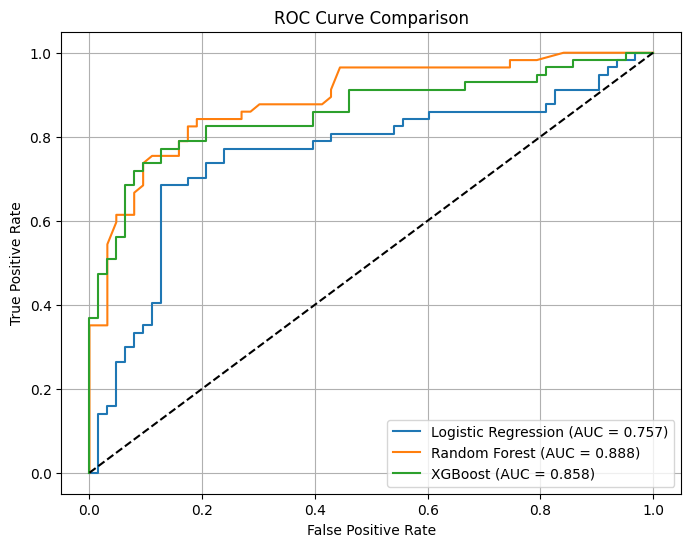

Logistic Regression AUC: 0.7566
Random Forest AUC: 0.8882
XGBoost AUC: 0.8583


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_prob_logreg = logreg.predict_proba(X_test_scaled)[:, 1]
y_prob_rf = rf_model.predict_proba(X_test_scaled)[:, 1]
y_prob_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]

fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_prob_logreg)
auc_logreg = auc(fpr_logreg, tpr_logreg)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
auc_rf = auc(fpr_rf, tpr_rf)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_logreg, tpr_logreg, label=f'Logistic Regression (AUC = {auc_logreg:.3f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.3f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.3f})')

plt.plot([0, 1], [0, 1], 'k--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid()
plt.show()
print(f"Logistic Regression AUC: {auc_logreg:.4f}")
print(f"Random Forest AUC: {auc_rf:.4f}")
print(f"XGBoost AUC: {auc_xgb:.4f}")


I evaluated three models to classify players into Low Elo and High Elo categories. The **Random Forest** model performed **best**, achieving the highest AUC score of **0.8882**, which indicates strong ability to distinguish between Low and High Elo players. The XGBoost model also performed well, with an AUC of 0.8583, showing solid predictive power. Logistic Regression lagged behind with an AUC of 0.7566, indicating it’s less effective for this classification task.

These results suggest that ensemble tree-based models like Random Forest and XGBoost are better suited for predicting player Elo levels compared to Logistic Regression, given the features used.